# Stake Shift Computation Litecoin

In [5]:
import blocksci
import blocksci.cluster_python
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm_notebook
from collections import defaultdict
%matplotlib notebook

In [28]:
# Load parsed chain
chain = blocksci.Blockchain("/home/abdallah/litecoin-data")

In [ ]:
# Load clusters
clusters = blocksci.cluster_python.ClusterManager("/home/abdallah/litecoin-data/clusters/")

In [ ]:
# Get Change Addresses
change_addrs = dict()
for block in tqdm_notebook(chain[:-10]):
    for tx in block:
        if (not tx.is_coinbase) and (not blocksci.heuristics.is_coinjoin(tx)):
            if blocksci.heuristics.unique_change_by_address_reuse(tx) is None:
                out = blocksci.heuristics.unique_change_by_client_change_address_behavior_legacy(tx)
                if out is not None:
                    if out.address not in change_addrs:
                        change_addrs[out.address] = 1
                    else:
                        change_addrs[out.address] = change_addrs[out.address] + 1

In [ ]:
# Checks if a given address is involved with Satoshi Bones
def isInvolvedSatoshi(addr):
    adr_out_txes = addr.out_txes()
    for out_tx in adr_out_txes:
        for txout in out_tx.outs:
            if str(txout.address.script)[:6] == "Lbones":
                return True
    return False

In [ ]:
# False Positive Computation
falsePositives = dict()
satoshi_count = 0
for addr in tqdm_notebook(change_addrs):
    in_txes_cnt = len(addr.in_txes())
    if in_txes_cnt == 2:
        if not isInvolvedSatoshi(addr):
            falsePositives[addr.script] = 1
        else : 
            satoshi_count += 1
    elif in_txes_cnt > 2:
        falsePositives[addr.script] = 1

In [ ]:
# Final Stake Computation Function
def computeStakesNew(clusters, falsePositives, heights):
    cluster_count = clusters.cluster_count()
    stakes_list = [[] for i in range(cluster_count)]
    for height in tqdm_notebook(heights):
        i = 0
        for cluster in clusters.clusters():
            stake = 0
            for script in cluster.scripts:
                if script not in falsePositives:
                    stake += script.balance(height)
            stakes_list[i].append(stake)
            i+=1
    for x in range(len(falsePositives)):
        stakes_list.append([])
    for h_idx, height in enumerate(heights):
        y = cluster_count
        for fp in falsePositives:
            stakes_list[y].append(fp.balance(height))
            y += 1
    return stakes_list

In [ ]:
# Compute stakes in terms of probabilities
def stakesProb(stakes, heights):
    p_stakes = []
    for i in range(0,len(heights)):
        stake = list(map(lambda x : x[i], stakes))
        p_stakes.append(np.array(stake) / np.sum(stake))
    return p_stakes

In [ ]:
# Compute the statistical distance
def statDist(p_stakes, heights):
    stat_dists = []
    for i in range(0, len(heights) -1):
        stat_dists.append(0.5 * np.sum(np.absolute(np.array(p_stakes[i]) - np.array(p_stakes[i+1]))))
    return stat_dists

In [3]:
# Evaluates the statistical distances
def evaluate(stat_dist):
    print ("Mean : %f" %(np.mean(stat_dist)))
    print ("Var : %f" %(np.var(stat_dist)))
    print ("Std Dev : %f" %(np.std(stat_dist, ddof=1)))

# Yearly Stake Shifts

In [ ]:
# Get heights of blocks for yearly stake shift computation
T = calendar.timegm(datetime(2018,2,1).timetuple())
T_blocks_year = chain.filter_blocks(lambda x : x.timestamp < T)
print(len(T_blocks_year))
heights = []
dates = [2012,2013,2014,2015,2016,2017]
for blk in T_blocks_year:
    if blk.time.year == dates[0]:
        print(blk.time.year)
        heights.append(blk.height)
        del dates[0]
        if len(dates) == 0:
            break;

In [ ]:
# Compute yearly stakes
stakes_t_year = computeStakesNew(clusters,falsePositives, heights)

In [ ]:
# Get the stakes in terms of probabilities
stake_probs = stakesProb(stakes_t_year, heights)

In [ ]:
stakes_2012 = list(map(lambda x : x[0], stake_probs))

In [ ]:
stakes_2013 = list(map(lambda x : x[1], stake_probs))

In [ ]:
stakes_2012 = stake_probs[0]
stakes_2013 = stake_probs[1]

In [ ]:
# Stake distributions plots
x = range(len(stakes_2012))
fig, axis1 = plt.subplots()
# prob_stakes = list(np.array(stakes_2012)/1e8)
axis1.bar(x, stakes_2012)
axis1.set_ylabel("Stake shift")
# axis1.set_xticks(range(len(stat_dists_h)))
# axis1.set_ylim([0,1.0])
# axis1.set_xticklabels(("2012-2013", "2013-2014","2014-2015", "2015-2016", "2016-2017"))

In [ ]:
x = range(len(stakes_2012))
df = pd.DataFrame({"Stakes at T1": np.array(stakes_2012[:65000]) }, index=x[:65000])
ax = df.plot(legend=False)
ax.set_ylim(0)
# ax.set_title("Stakes at time T1")
ax.set_xlabel("Address number")
# ax.set_yscale("log",nonposy="clip")
ax.set_ylabel("Stake")

In [ ]:
x = range(len(stakes_2013))
df = pd.DataFrame({"Stakes at T1": np.array(stakes_2013[:65000]) }, index=x[:65000])
ax = df.plot(legend=False)
ax.set_ylim(0)
# ax.set_title("Stakes at time T1")
ax.set_xlabel("Address number")
# ax.set_yscale("log",nonposy="clip")
ax.set_ylabel("Stake")

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_year, heights), heights)

In [ ]:
evaluate(stat_dists)

In [ ]:
del stakes_t_year_year
del stat_dists

# Monthly Stake Shift

In [ ]:
# Get heights of blocks for monthly stake shift computation
T1 = calendar.timegm(datetime(2012,12,31).timetuple())
T2 = calendar.timegm(datetime(2014,1,1).timetuple())
T_blocks_month = chain.filter_blocks(lambda x : x.timestamp > T1 and x.timestamp < T2)
heights = []
months = list(range(1,13))
for blk in T_blocks_month:
    if blk.time.month == months[0]:
        heights.append(blk.height)
        del months[0]
        if len(months) == 0:
            break;

In [ ]:
stakes_t_month = computeStakesNew(clusters,falsePositives, heights)

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_month, heights), heights)

In [ ]:
evaluate(stat_dists)

In [ ]:
import os 

x = range(len(stat_dists))
fig, axis1 = plt.subplots()

axis1.bar(x, stat_dists)
axis1.set_ylabel("Stake shift")
axis1.set_xticks(range(len(stat_dists)))
axis1.set_ylim([0,0.35])
axis1.set_xticklabels(("Jan-Feb", "Feb-Mar","Mar-April", "April-May", "May-June", "June-July", "July-Aug", "Aug-Sep", "Sep-Oct", "Oct-Nov", "Nov-Dec"),rotation=45,ha="right")

In [ ]:
del stakes_t_month

# Weekly Stake Shift

In [ ]:
# Get heights of blocks for weekly stake shift computation
T1 = calendar.timegm(datetime(2015,12,31).timetuple())
T2 = calendar.timegm(datetime(2017,1,1).timetuple())
T_blocks_month = chain.filter_blocks(lambda x : x.timestamp > T1 and x.timestamp < T2)
heights = []
weeks = [1,8,15,22,29]
months = [10,11] # Get stakes for every week of months

for blk in T_blocks_month:
    if blk.time.month == months[0]:
        if blk.time.day == weeks[0]:
            heights.append(blk.height)
            del weeks[0]
            if len(weeks) == 0:
                del months[0]
                weeks = [1,8,15,22,29]
                if len(months) == 0:
                    break;

In [ ]:
stakes_t_weekly = []
computeStakes(stakes_t_weekly, clusters.clusters(),falsePositives, heights)

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_weekly, heights), heights)

In [ ]:
del stat_dists[4]

In [ ]:
evaluate(stat_dists)

In [ ]:
import os 

x = range(len(stat_dists))

fig, axis1 = plt.subplots()
axis1.bar(x, stat_dists)
axis1.set_ylabel("Stake shift")
axis1.set_xticks(range(len(stat_dists)))
axis1.set_xticklabels(("AugW1-AugW2", "AugW2-AugW3","AugW3-AugW4", "AugW4", "SepW1-SepW2", "SepW2-SepW3", "SepW3-SepW4", "SepW4"),rotation=45,ha="right")

In [ ]:
del stakes_t_weekly

# Daily Stake Shift

In [ ]:
# Get heights of blocks for weekly stake shift computation
T1 = calendar.timegm(datetime(2014,1,31).timetuple())
T2 = calendar.timegm(datetime(2014,4,1).timetuple())
T_blocks_month = chain.filter_blocks(lambda x : x.timestamp > T1 and x.timestamp < T2)
heights = []
days = list(range(1,32))
month = 3 # December
# months = [11,12] # Get stakes for every week of Nov and Dec

for blk in T_blocks_month:
    if blk.time.year == 2014:
        if blk.time.month == month:
            if blk.time.day == days[0]:
                heights.append(blk.height)
                del days[0]
                if len(days) == 0:
                    break;

In [ ]:
stakes_t_daily = computeStakesNew(clusters, falsePositives, heights)

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_daily, heights), heights)

In [ ]:
stat_dists

In [ ]:
stat_dists = [0.004228147393279441,
 0.005830400148499495,
 0.01903068328453799,
 0.013198674355844448,
 0.006531507104055283,
 0.005672397374652413,
 0.008635692486950983,
 0.1724657390816944,
 0.004185325017258931,
 0.0119502722446238,
 0.006555634764443115,
 0.004513564316690012,
 0.006319384551023752,
 0.019155361948026365,
 0.008427100768668112,
 0.012269559746210553,
 0.014767077683986106,
 0.007933466394616406,
 0.016989066713793573,
 0.006659876361173962,
 0.005202543723824965,
 0.002802939145608437,
 0.007187900339335251,
 0.009422491487475834,
 0.013888109442417671,
 0.004364306066160262,
 0.0066841634667438275,
 0.0036991890170084596,
 0.0034148117390475287,
 0.007276201046600854]

In [ ]:
del stat_dists[7]

In [ ]:
evaluate(stat_dists)

In [ ]:

x = range(1,len(stat_dists)+1)

fig, axis1 = plt.subplots()

axis1.bar(x, stat_dists, align='center', width=0.8)
axis1.set_ylabel("Stake shift")
axis1.set_xlabel("Days of the month")

axis1.set_ylim([0,0.06])
axis1.set_xticks(x)
axis1.set_xticklabels((x),rotation=45)
# axis1.set_xticklabels(("","NovW1-NovW2", "NovW2-NovW3","NovW3-NovW4", "NovW4-DecW1", "DecW1-DecW2", "DecW2-DecW3", "DecW3-DecW4"),rotation=45,ha="right")



In [ ]:
del stakes_t_daily

# Per Block Stake Shift

In [29]:
# Get heights of blocks for daily stake shift computation
T1 = calendar.timegm(datetime(2017,4,13).timetuple())
T2 = calendar.timegm(datetime(2017,4,14).timetuple())
T_blocks_day = chain.filter_blocks(lambda x : x.timestamp > T1 and x.timestamp < T2)
heights = []
for blk in T_blocks_day:
    heights.append(blk.height)

In [ ]:
stakes_t_block = computeStakesNew(clusters,falsePositives, heights[175:275])

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_block, heights[175:275]), heights[175:275])

In [ ]:
import pickle 

with open('ltc_block_sh_3', 'wb') as file:
    pickle.dump(stat_dists, file)

In [ ]:
del stakes_t_block
del stat_dists

In [ ]:
stakes_t_block = computeStakesNew(clusters,falsePositives, heights[475:575])

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_block, heights[475:575]), heights[475:575])

In [ ]:
with open('ltc_block_sh_4', 'wb') as file:
    pickle.dump(stat_dists, file)

In [ ]:
del stakes_t_block
del stat_dists

In [ ]:
len(stakes_t_block[594563]), len(heights)

del stakes_t_block_old

In [ ]:
stakes_t_block_old = [] 
computeStakes(stakes_t_block_old,clusters.clusters(),falsePositives, [heights[75]])

In [ ]:
list(map(lambda x : x[0], stakes_t_block_old)) == list(map(lambda x : x[0], stakes_t_block))

In [ ]:
stat_dists = statDist(stakesProb(stakes_t_block, heights[75:175]), heights[75:175])

In [ ]:
evaluate(stat_dists_disk)

In [ ]:
np.std(stat_dists_disk,ddof=1)

In [ ]:

x = range(1,len(stat_dists)+1)

fig, axis1 = plt.subplots()

axis1.bar(x, stat_dists, align='center', width=0.8)
axis1.set_ylabel("Stake shift")
axis1.set_xlabel("Block")

In [ ]:
import pickle 

with open('ltc_block_sh_2', 'wb') as file:
    pickle.dump(stat_dists, file)

In [1]:
import pickle 
stat_dists = []
with open('ltc_block_sh', 'rb') as file:
    stat_dists = pickle.load(file)

In [9]:
stat_dists2 = []
with open('ltc_block_sh_2', 'rb') as file:
    stat_dists2 = pickle.load(file)

In [13]:
stat_dists3 = []
with open('ltc_block_sh_3', 'rb') as file:
    stat_dists3 = pickle.load(file)

In [17]:
stat_dists4 = []
with open('ltc_block_sh_4', 'rb') as file:
    stat_dists4 = pickle.load(file)

In [18]:
evaluate(stat_dists4)

Mean : 0.000020
Var : 0.000000
Std Dev : 0.000086


In [19]:
np.var(stat_dists4)

7.311524750849577e-09

In [15]:
len(stat_dists3)

99

In [50]:
heights1 = heights[475:575]

In [ ]:
chain[heights1[50]].input_value-chain[heights1[50]].output_value

In [51]:
out_values = []
for h in heights1:
    out_values.append(chain[h].output_value)
norm_out_values = np.array(out_values) / np.sum(out_values)

In [52]:
norm_out_values = np.array(out_values) / np.sum(out_values)

In [ ]:
chain[heights1[0]].output_value 

In [ ]:
stat_dists_disk[0]

In [ ]:
np.median(stat_dists)

In [ ]:
from scipy import stats
m = stats.mode(np.array(stat_dists))
print(m[0])
print(m[1])

In [ ]:
chain[heights1[0]].time.hour

# Understanding Stake shift (Associations with Volume, Price, Block Output Value)

In [140]:
volumes_2014_str =["7,248,790", "10,933,600", "3,442,020", "20,549,800", "25,956,800", "7,946,950", "6,448,800", "8,181,220", "2,493,740", "6,305,450", "18,958,100", "15,946,500", "35,045,000", "28,101,700", "6,764,140", "5,627,180", "3,080,560", "4,006,980", "4,116,820", "12,417,500", "3,714,800", "5,340,680", "6,666,580", "5,923,750", "6,222,120", "8,044,810", "11,390,300", "47,109,100", "17,573,800", "3,812,480", "3,267,220"]

In [141]:
volumes_2014_rev = volumes_2014_str[::-1]

In [216]:
volumes_2017_rev[-1]

'98,922,600'

In [217]:
volumes_2017 = [int(x.replace(",","")) for x in volumes_2017_rev]

In [143]:
stat_dists_daily_2014 = [0.014291122061695126,
 0.011729100020567089,
 0.01803756759508095,
 0.038188021364326925,
 0.016175630375501064,
 0.009473617669006616,
 0.008912949140875233,
 0.006499180503345936,
 0.006226755240393181,
 0.0073253837951858655,
 0.006881014496969389,
 0.016373949847827425,
 0.005304292561241198,
 0.005102499822028463,
 0.0064387955784965265,
 0.008000694844483815,
 0.010456890264980364,
 0.01672954943437949,
 0.027003766859625754,
 0.014700826177234437,
 0.015892584857797255,
 0.009076292380738841,
 0.006380513557022265,
 0.0074326892551324335,
 0.004494799339119913,
 0.007083040240966617,
 0.016115303192086462,
 0.009052054349732821,
 0.006016374638532558,
 0.016071682889388695]

In [144]:
np.corrcoef(volumes_2014[1:], stat_dists_daily_2014)[0,1]

0.295329220460391

In [77]:
import os
ltc_prices_loc = os.path.join(os.getcwd(),'ltc-usd-max.csv')
ltc_prices = pd.read_csv(ltc_prices_loc)

In [86]:
ltc_prices.iloc[100]

snapped_at      2013-08-07 00:00:00 UTC
price                           2.76763
market_cap                  5.56514e+07
total_volume                          0
Name: 100, dtype: object

In [78]:
datetime.strptime(ltc_prices.iloc[1]['snapped_at'].replace(" UTC", ""),'%Y-%m-%d %X')

datetime.datetime(2013, 4, 29, 0, 0)

In [ ]:
# Get LTC price
idxes = []
times = []
for h in heights1:
    times.append(chain[h].time)
hours = list(range(0,24))# Get stakes for every hour

day = 15
month = 11
year = 2016

for index, row in btc_prices.iterrows():
    row_date = datetime.strptime(row['Date'],'%Y-%m-%d %X')
    if row_date.month == month and row_date.day == day and row_date.year == year:
        if row_date.hour == hours[0]:
            idxes.append(index)
            del hours[0]
            if len(hours) == 0:
                break;

In [149]:
abs_vol_diff = []
for i in range(0, len(volumes_2016) -1):
    abs_vol_diff.append(np.absolute(volumes_2016[i] - volumes_2016[i+1]))

In [232]:
import scipy.stats
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.08031145717463849, pvalue=0.6731160927086494)

In [231]:
np.corrcoef(x,y)[0,1]

0.02959281658623067

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Text(0,0.5,'Daily Stake Shift')

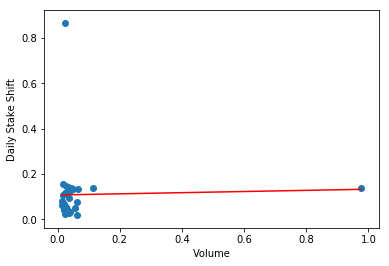

In [230]:
y = list(np.array(stat_dists_daily_2017)/np.linalg.norm(np.array(stat_dists_daily_2017)))
x = list(np.array(volumes_2017[:-1])/np.linalg.norm(np.array(volumes_2017[:-1])))
fig, ax = plt.subplots()
ax.scatter(y=y, x=x)
ax.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x)), color='red')
fig.show()
ax.set_xlabel("Volume")
ax.set_ylabel("Daily Stake Shift")


<Container object of 30 artists>

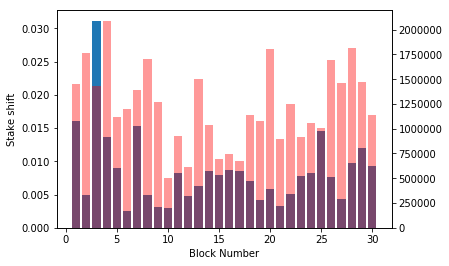

In [126]:
x = range(1,len(stat_dists_daily_2016)+1)

fig, axis1 = plt.subplots()
# fig2, axis2 = plt.subplots()

axis2 = axis1.twinx()
axis1.bar(x, stat_dists_daily_2016, align='center', width=0.8)
axis1.set_ylabel("Stake shift")
axis1.set_xlabel("Block Number")
# axis1.set_ylim([0,0.0016])
axis2.bar(range(len(volumes_2016))[1:], volumes_2016[1:], color='red', alpha=0.4)
# axis2.plot(df2,'red')
# axis2.set_ylabel("BTC price in $")
# axis2.set_xticks((x))
# axis2.grid(b=False)
# axis1.set_xticks(x)
# axis1.set_xticklabels((x),rotation=45)
# axis1.set_xticklabels(("","NovW1-NovW2", "NovW2-NovW3","NovW3-NovW4", "NovW4-DecW1", "DecW1-DecW2", "DecW2-DecW3", "DecW3-DecW4"),rotation=45,ha="right")
# btc_price_handle = matplotlib.patches.Patch(color='red',label='Abs BTC price change', alpha=0.4)
# stake_shift_handle = matplotlib.patches.Patch(color='C0',label='Stake shift')
# fig.legend(handles=[btc_price_handle,stake_shift_handle])


In [ ]:
len(out_values[41:50]), len(stat_dists_disk[40:49])

In [ ]:
chain[heights1[40]].time.hour

In [211]:
np.corrcoef(x,y)[0,1]

0.7512321419397808

In [274]:
# QQ PLOTS AND SHAPIRO WILK TESTS FOR NORMALITY
import statsmodels.api as sm
import pylab

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [291]:
test_data = np.random.normal(0,1,len(stat_dists_daily_2014))

In [298]:
scipy.stats.shapiro(volumes_2014)

(0.7589969038963318, 9.805899935599882e-06)

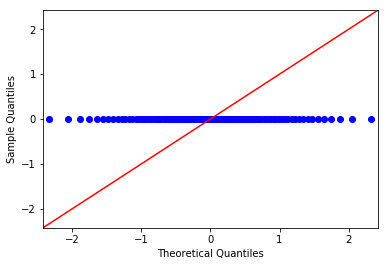

In [294]:
sm.qqplot(np.array(stat_dists), line='45')
pylab.show()

In [252]:
# Get heights of blocks for daily stake shift computation
T1 = calendar.timegm(datetime(2017,4,13).timetuple())
T2 = calendar.timegm(datetime(2017,4,14).timetuple())
T_blocks_day = chain.filter_blocks(lambda x : x.timestamp > T1 and x.timestamp < T2)
heights = []
for blk in T_blocks_day:
    heights.append(blk.height)

In [267]:
heights1 = heights[175:275]

In [272]:
import scipy.stats
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.8821225016663485, pvalue=1.7598902874348177e-33)

In [273]:
np.corrcoef(x,y)[0,1]

0.7327428507325143

In [268]:
# Out values computation
out_values = []
for h in heights1:
    out_values.append(chain[h].output_value)
norm_out_values = np.array(out_values) / np.sum(out_values)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Text(0,0.5,'Stake Shift : Block Time Interval')

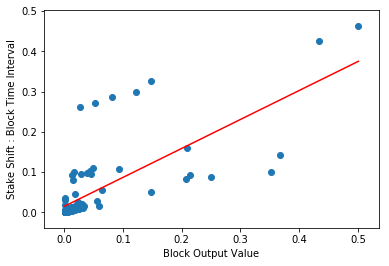

In [269]:
# Correlation scatter plot between out_values and stat dists
x = list(np.array(stat_dists3)/np.linalg.norm(np.array(stat_dists3)))
y = list(np.array(out_values[1:])/np.linalg.norm(np.array(out_values[1:])))
fig, ax = plt.subplots()
ax.scatter(y=y, x=x)
ax.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x)), color='red')
fig.show()
ax.set_xlabel("Block Output Value")
ax.set_ylabel("Stake Shift : Block Time Interval")

# Out Value Daily Stake Shift Correlation

In [380]:
# Get heights of blocks for weekly stake shift computation
T1 = calendar.timegm(datetime(2017,3,1).timetuple())
T2 = calendar.timegm(datetime(2017,4,1).timetuple())
T_blocks_month = chain.filter_blocks(lambda x : x.timestamp > T1 and x.timestamp < T2)
daily_out_values_17 = []
days = list(range(1,32))
month = 3 # December
# months = [11,12] # Get stakes for every week of Nov and Dec
for day in days:
    out_val = 0
    for blk in T_blocks_month:
        if blk.time.month == month:
            if blk.time.day == day:
                out_val += chain[blk.height].output_value
    daily_out_values_17.append(out_val)

In [391]:
stat_dists_daily_2016 = [0.016096035254624406,
 0.005003604210986567,
 0.03116935562219343,
 0.013707775985647073,
 0.008970945872496644,
 0.0024846034491686395,
 0.015372483963885549,
 0.004999970503909164,
 0.0031540649789399103,
 0.0029343968852261586,
 0.008247943547127419,
 0.004761662154428153,
 0.006322026559592211,
 0.008523335000604426,
 0.007989241547064195,
 0.008746973983405366,
 0.008491019160090941,
 0.007016967097659603,
 0.004219825768752152,
 0.005855405253345231,
 0.00324582806548929,
 0.005128018364154707,
 0.007856567978328385,
 0.008241006982907625,
 0.014590749289510223,
 0.007656862605157915,
 0.0043888988903117016,
 0.009799289673502644,
 0.012044792710442126,
 0.009228965397337061]

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Text(0,0.5,'Stake Shift : Day Time Interval')

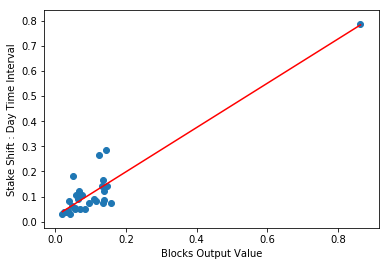

In [394]:
x = list(np.array(stat_dists_daily_2017)/np.linalg.norm(np.array(stat_dists_daily_2017)))
y = list(np.array(daily_out_values_17[:-1])/np.linalg.norm(np.array(daily_out_values_17[:-1])))
fig, ax = plt.subplots()
ax.scatter(y=y, x=x)
ax.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x)), color='red')
fig.show()
ax.set_xlabel("Blocks Output Value")
ax.set_ylabel("Stake Shift : Day Time Interval")

<Container object of 30 artists>

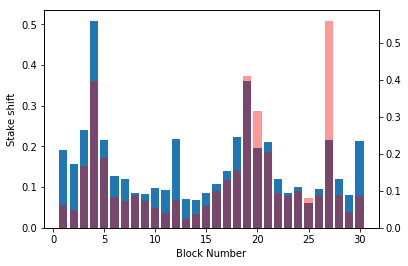

In [368]:
x = range(1,len(stat_dists_daily_2014)+1)
# x2 = range(1, len(mod_stat_dists)+1 )
# df = pd.DataFrame({"Stakes at T3": stat_dists_month_h2 }, index=x)

#         btc_prices_loc = os.path.join(os.getcwd(),'btc-2013.csv')
#         btc_prices = pd.read_csv(btc_prices_loc)
# btc_prices.iloc[idxes]['Close Price']

# df2 = pd.DataFrame({"BTC price": out_values }, index=range(len(out_values))[1:26])
# btc_prices.iloc[idxes]
# df2

fig, axis1 = plt.subplots()
# fig2, axis2 = plt.subplots()

axis2 = axis1.twinx()
axis1.bar(x, list(np.array(stat_dists_daily_2014)/np.linalg.norm(np.array(stat_dists_daily_2014))), align='center', width=0.8)
axis1.set_ylabel("Stake shift")
axis1.set_xlabel("Block Number")
# axis1.set_ylim([0,0.0016])
axis2.bar(range(len(daily_out_values))[1:], list(np.array(daily_out_values[:-1])/np.linalg.norm(np.array(daily_out_values[:-1]))), color='red', alpha=0.4)
# axis2.plot(df2,'red')
# axis2.set_ylabel("BTC price in $")
# axis2.set_xticks((x))
# axis2.grid(b=False)
# axis1.set_xticks(x)
# axis1.set_xticklabels((x),rotation=45)
# axis1.set_xticklabels(("","NovW1-NovW2", "NovW2-NovW3","NovW3-NovW4", "NovW4-DecW1", "DecW1-DecW2", "DecW2-DecW3", "DecW3-DecW4"),rotation=45,ha="right")
# btc_price_handle = matplotlib.patches.Patch(color='red',label='Abs BTC price change', alpha=0.4)
# stake_shift_handle = matplotlib.patches.Patch(color='C0',label='Stake shift')
# fig.legend(handles=[btc_price_handle,stake_shift_handle])


In [393]:
# Spearman's Rank Order Correlation Coefficient computation
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.5666295884315907, pvalue=0.0010965641649193633)